In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': '.9', 'grid.color': '.8'}
)
sns.set_palette(palette='deep')
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from kernels import kernel

### Gaussian Processes 
$\text{f_x} \sim GP(\mu, k) \\\mu(\mathbf{x}) = \text{mean} \\k(\mathbf{x}, \mathbf{x}') = \text{covariance}$

In [2]:
def data(sammple_size, sigma):
    x = np.linspace(start=0, stop=1, num=sammple_size)
    f_x = np.sin((4*np.pi)*x) + np.sin((7*np.pi)*x)
        
    epsilon = np.random.normal(loc=0, scale=sigma, size=sammple_size)
    
    # Observed Data
    y = f_x + epsilon
    
    return x, y, f_x

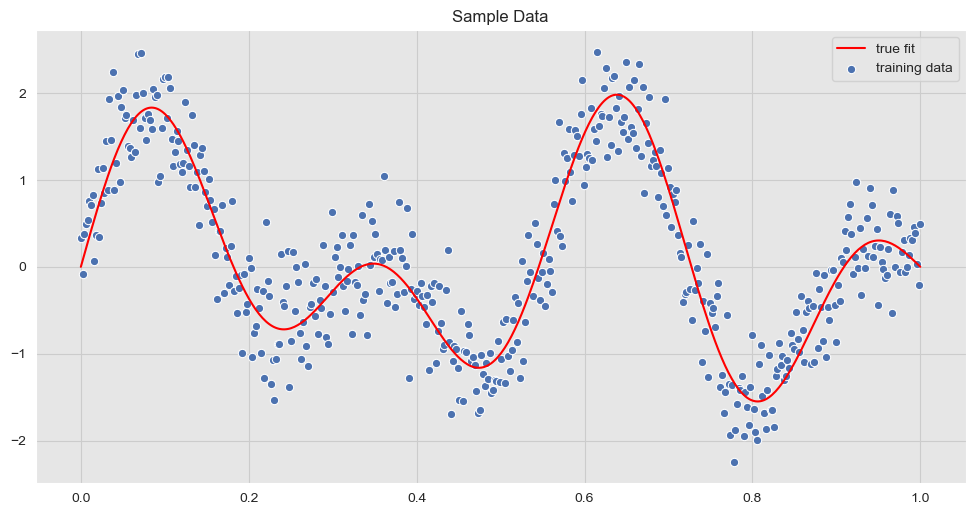

In [3]:
NUM_OF_FEATURES = 1
SIGMA = 0.4

TRAIN_SAMPLES = 500
X_TRAIN, Y_TRAIN, TRUE_FIT = data(TRAIN_SAMPLES, SIGMA)


fig, ax = plt.subplots()
# TRAINING DATA
sns.scatterplot(x=X_TRAIN, y=Y_TRAIN, label='training data', ax=ax);
# TRUE FIT
sns.lineplot(x=X_TRAIN, y=TRUE_FIT, color='red', label='true fit', ax=ax);
ax.set(title='Sample Data')
ax.legend(loc='upper right');

In [4]:
TEST_SAMPLES = 100

X_TEST = np.linspace(start=0, stop=1, num=TEST_SAMPLES)

### Initialize Kernel 

#### RBF kernel has 2 hyper parameters length_scale and output_variance

[cookbook](https://www.cs.toronto.edu/~duvenaud/cookbook/)

The *length_scale* determines the length of the 'wiggles' in your function. In general, you won't be able to extrapolate more than lenght_scale units away from your data.

The *output_variance* determines the average distance of your function away from its mean

In [5]:
def compute_covariance_matrix(length_scale, output_variance):
    x_train = np.array(X_TRAIN).reshape(TRAIN_SAMPLES, NUM_OF_FEATURES)
    x_test = np.array(X_TEST).reshape(TEST_SAMPLES, NUM_OF_FEATURES)
    
    K = kernel.RBF(x_train, length_scale=length_scale, output_variance=output_variance)
    
    K_STAR_STAR = kernel.RBF(x_test, length_scale=length_scale, output_variance=output_variance)
    
    K_STAR = kernel.RBF(x_train, length_scale=length_scale, output_variance=output_variance)
    K_STAR = [K_STAR.decision(np.array(test_data).reshape(1, NUM_OF_FEATURES)) for test_data in x_test]
    
    return K.input_kernel_matrix, K_STAR_STAR.input_kernel_matrix, np.array(K_STAR)
    

### Covariance
$\Sigma = \begin{pmatrix} K, K_* \\K_*^\top , K_{**} \end{pmatrix}$

where $K$ is the training kernel matrix, $K_* $ is the training-testing kernel matrix, $K_*^\top$ is the testing-training kernel matrix and $K_{**}$ is the testing kernel matrix

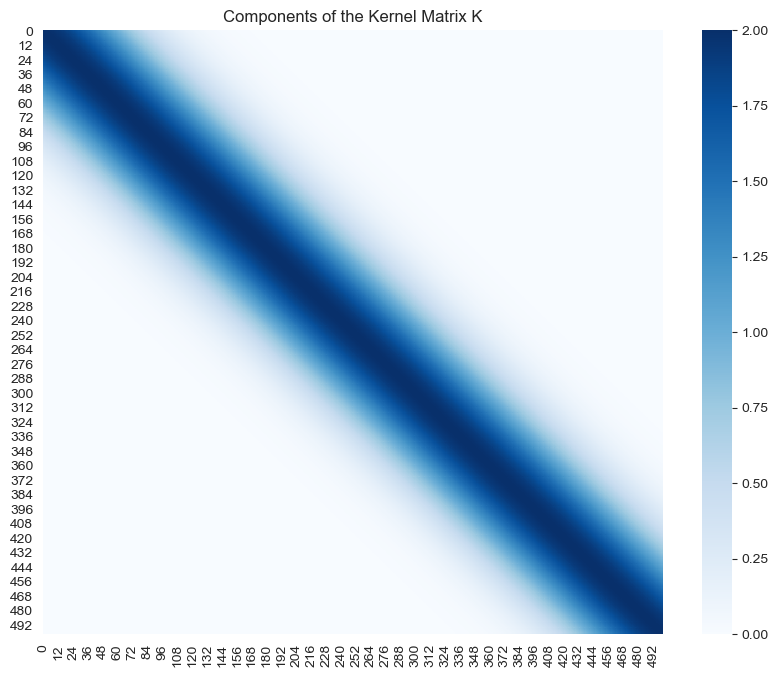

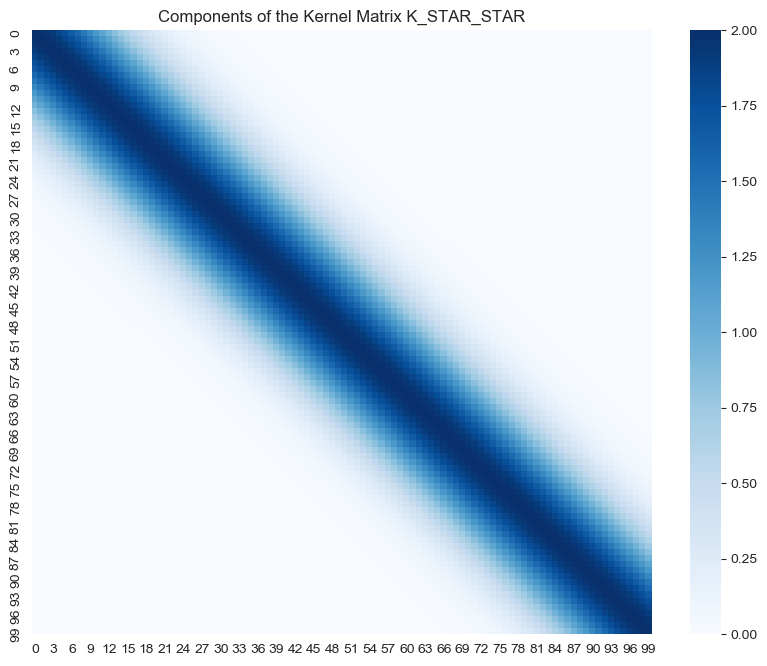

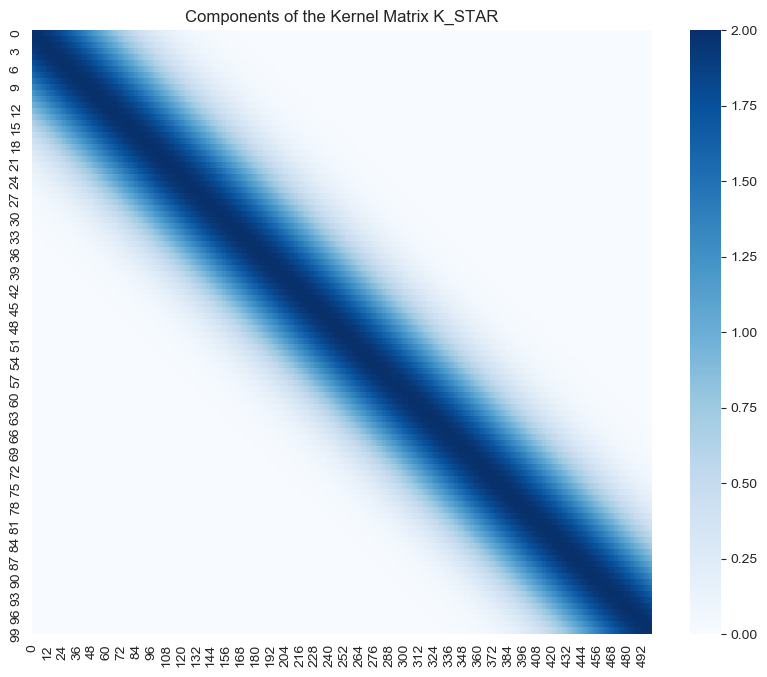

In [6]:
K, K_STAR_STAR, K_STAR = compute_covariance_matrix(0.1, 2)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(data=K, cmap='Blues', ax=ax)
ax.set(title='Components of the Kernel Matrix K');

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(data=K_STAR_STAR, cmap='Blues', ax=ax)
ax.set(title='Components of the Kernel Matrix K_STAR_STAR');

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(data=K_STAR, cmap='Blues', ax=ax)
ax.set(title='Components of the Kernel Matrix K_STAR');

#### Computing the Joined covariace matrix
$COVARIANCE = 
\left(
\begin{array}{cc}
K(\text{X_TRAIN}, \text{X_TRAIN}) + \sigma^2_n I & K(\text{X_TRAIN}, \text{X_TEST}) \\
K(\text{X_TEST}, \text{X_TRAIN}) & K(\text{X_TEST}, \text{X_TEST})
\end{array}
\right)$

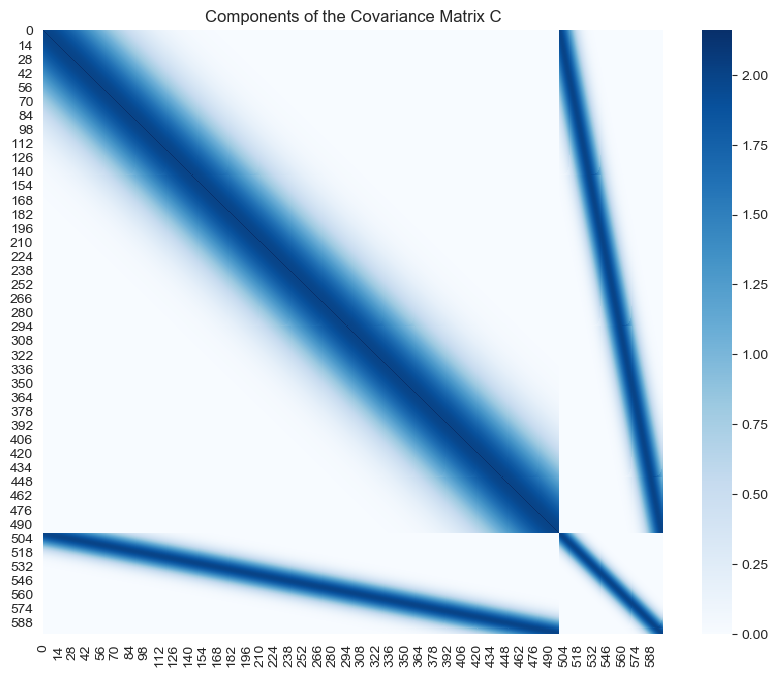

In [7]:
COVARIANCE = np.concatenate((np.concatenate((K + (SIGMA**2)*np.eye(TRAIN_SAMPLES), K_STAR), axis=0), np.concatenate((K_STAR.T, K_STAR_STAR), axis=0)), axis=1)
assert (np.all(COVARIANCE.T == COVARIANCE)), ("SOMETHING WENT WRONG WHILE COMPUTING COVARIANCE, THE MATRIX SHOULD BE SYMMETRIC")

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(data=COVARIANCE, cmap='Blues', ax=ax)
ax.set(title='Components of the Covariance Matrix C');

#### PRIOR

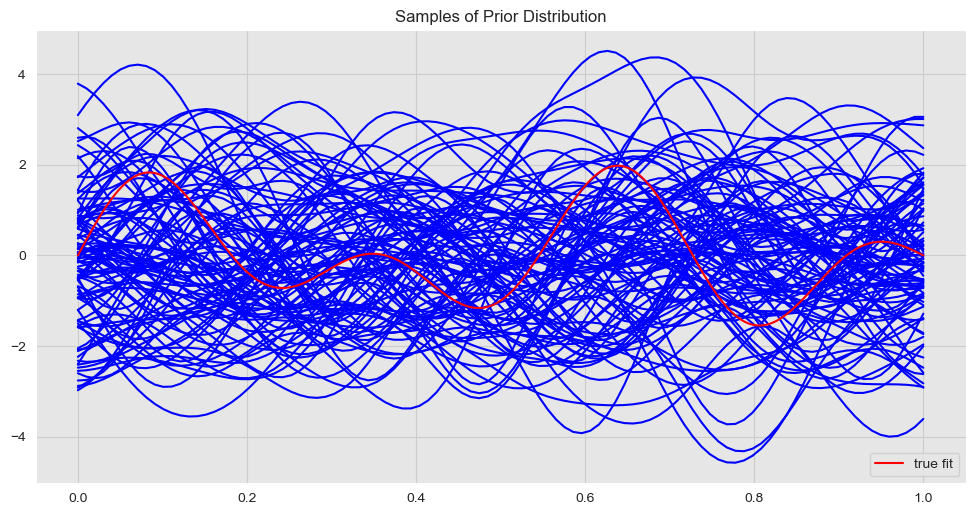

In [8]:
fig, ax = plt.subplots()

for i in range(0, 100):
    prior_distribution = np.random.multivariate_normal(mean=np.zeros(TEST_SAMPLES), cov=K_STAR_STAR)
    sns.lineplot(x=X_TEST, y=prior_distribution, color='blue', ax=ax)

# TRUE FIT
sns.lineplot(x=X_TRAIN, y=TRUE_FIT, color='red', label='true fit', ax=ax)
ax.set(title='Samples of Prior Distribution')
ax.legend(loc='lower right');

$\begin{equation}
f_*|(Y_1=y_1,...,Y_n=y_n,\mathbf{x}_1,...,\mathbf{x}_n,\mathbf{x}_t)\sim \mathcal{N}(K_* (K^{-1}+ \sigma^2_n I)y,K_{**}-K_* (K^{-1}+ \sigma^2_n I)K_*^\top)
\end{equation}$


In [9]:
def compute_conditional_parameters():
    mean_conditional = np.dot(K_STAR,np.dot(np.linalg.inv(K + (SIGMA**2)*np.eye(TRAIN_SAMPLES)),Y_TRAIN.reshape((NUM_OF_FEATURES, TRAIN_SAMPLES)).T))
    
    covariance_conditional = K_STAR_STAR - np.dot(K_STAR, np.dot(np.linalg.inv(K + (SIGMA**2)*np.eye(TRAIN_SAMPLES)), K_STAR.T))
    
    return mean_conditional, covariance_conditional

In [10]:
MEAN_CONDITIONAL, COVARIANCE_CONDITIONAL = compute_conditional_parameters()

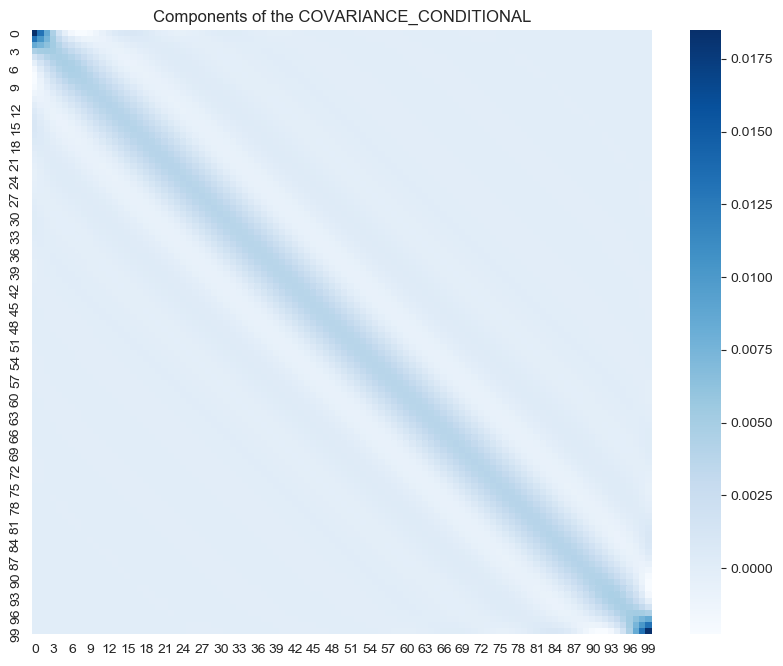

In [11]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(data=COVARIANCE_CONDITIONAL, cmap='Blues', ax=ax)
ax.set_title('Components of the COVARIANCE_CONDITIONAL');

### POSTERIOR 

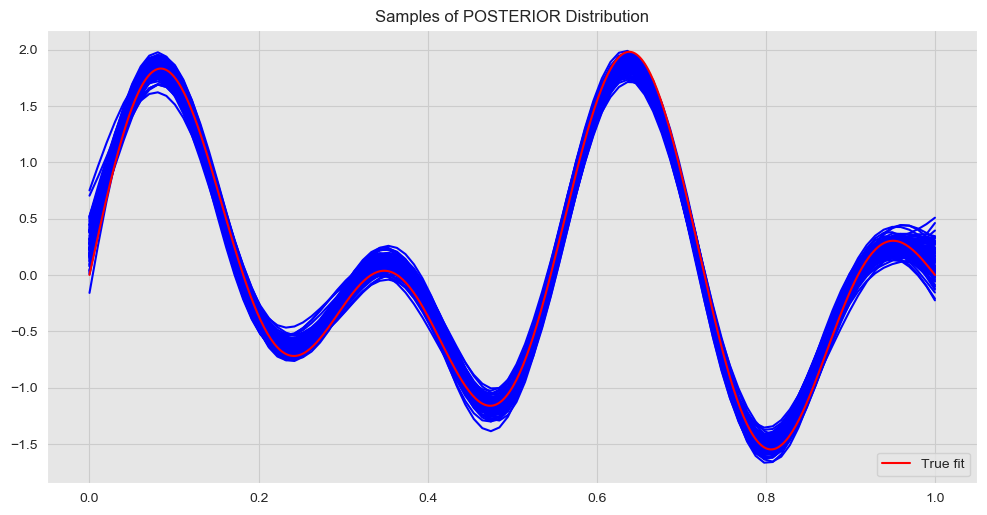

In [12]:
fig, ax = plt.subplots()

for i in range(0, 100):
    posterior_distribution = np.random.multivariate_normal(mean=MEAN_CONDITIONAL.squeeze(), cov=COVARIANCE_CONDITIONAL)
    sns.lineplot(x=X_TEST, y=posterior_distribution, color="blue", ax=ax)
    
# TRUE FIT
sns.lineplot(x=X_TRAIN, y=TRUE_FIT, color='red', label='True fit', ax=ax)
ax.set(title='Samples of POSTERIOR Distribution')
ax.legend(loc='lower right');

### CONFIDENCE INTERVAL


In [13]:
y_hat_samples = np.random.multivariate_normal(mean=MEAN_CONDITIONAL.squeeze(), cov=COVARIANCE_CONDITIONAL, size=200)
y_hat = np.apply_over_axes(func=np.mean, a=y_hat_samples, axes=0).squeeze()
y_hat_sd = np.apply_over_axes(func=np.std, a=y_hat_samples, axes=0).squeeze()

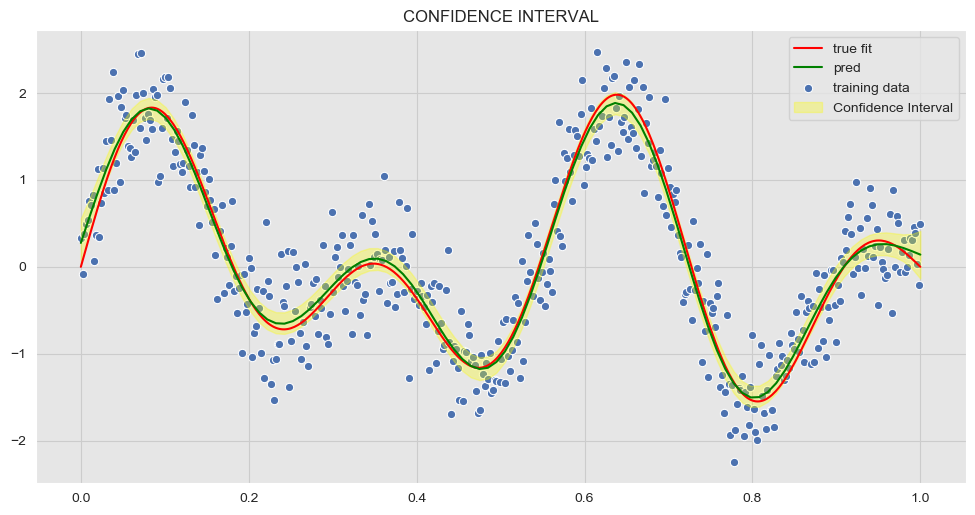

In [14]:
fig, ax = plt.subplots()
sns.scatterplot(x=X_TRAIN, y=Y_TRAIN, label='training data', ax=ax)
# Plot corridor. 
ax.fill_between(
    x=X_TEST, 
    y1=(y_hat - 2*y_hat_sd), 
    y2=(y_hat + 2*y_hat_sd), 
    color='yellow', 
    alpha = 0.3, 
    label='Confidence Interval'
)
# Plot "true" linear fit.
sns.lineplot(x=X_TRAIN, y=TRUE_FIT, color='red', label='true fit', ax=ax);
# Plot prediction. 
sns.lineplot(x=X_TEST, y=MEAN_CONDITIONAL.squeeze(), color='green', label='pred', ax=ax)
ax.set_title('CONFIDENCE INTERVAL')
ax.legend(loc='upper right');